### The goal is to export  the DevoLearn nucleus segmentation model to ONNX and run inference using ONNX runtime.

Link to tutorial - https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

In [ ]:
!pip install segmentation-models-pytorch
!pip install onnx
!git clone https://github.com/DevoLearn/devolearn.git
!pip install onnxruntime

### Import Libraries:

In [ ]:
import torch
import segmentation_models_pytorch as smp
import torch.onnx
import numpy as np
import onnx
import onnxruntime as ort

import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Load model:
`model.eval()` sets model to inference mode -
* Normalization layers use running stats.
* deactivate dropout layers

In [ ]:
model = torch.load('/content/devolearn/devolearn/cell_nucleus_segmentor/cell_nucleus_segmentation_model.pth', map_location='cpu')
model.eval()

### Define sample input `x` :
* The values in this can be random as long as it is the right type and size.
* In this case, `x` is a tensor, that corresponds to a batch of one single channel, 256x256 image.
* Make sure `out` is valid.

In [ ]:
x = torch.randn(1, 1, 256, 256, requires_grad=False)
out=model(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Export model:


In [ ]:
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "nucleus_segmentor.onnx", # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


### Define `expand_dims_twice`:


In [ ]:
def expand_dims_twice(arr):
    norm=(arr-np.min(arr))/(np.max(arr)-np.min(arr)) #normalize
    ret = np.expand_dims(np.expand_dims(norm, axis=0), axis=0)
    return(ret)

### Run inference from ONNX file:
The output image below the following cell is inferred from the ONNX model.

dims before expand_dims_twice -  (256, 256)
dims after expand_dims_twice -  (1, 1, 256, 256)


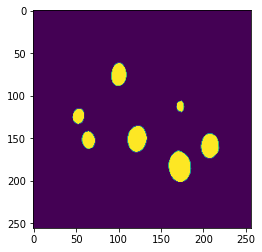

In [ ]:
ort_session = ort.InferenceSession('nucleus_segmentor.onnx')

img = cv2.imread("/content/devolearn/devolearn/tests/sample_data/images/nucleus_seg_sample.png",0)
resized = cv2.resize(img, (256,256),
               interpolation = cv2.INTER_NEAREST)

print("dims before expand_dims_twice - ", resized.shape)
img_unsqueeze = expand_dims_twice(resized)
print("dims after expand_dims_twice - ", img_unsqueeze.shape)

onnx_outputs = ort_session.run(None, {'input': img_unsqueeze.astype('float32')})
plt.imshow(onnx_outputs[0][0][0])
plt.show()